In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [2]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 44.0 MB/s eta 0:00:00


In [3]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.6 MB/s eta 0:00:00


In [4]:
# Libraries
import os
import pandas as pd
import cv2
from tqdm.notebook import tqdm
from PIL import Image
import cv2
import ultralytics
from ultralytics import YOLO
import numpy as np
import random

#tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import *
import keras_cv

#matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import seaborn as sns

#
import wandb
wandb.init(mode="disabled")
import shutil

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Data
train_path = '/content/drive/MyDrive/AcneDataset/train'
test_path = '/content/drive/MyDrive/AcneDataset/test'
val_path = '/content/drive/MyDrive/AcneDataset/valid'

In [7]:
train_images = os.listdir(train_path+'/images')
test_images = os.listdir(test_path+'/images')
val_images = os.listdir(val_path+'/images')
train_labels = os.listdir(train_path+'/labels')
test_labels = os.listdir(test_path+'/labels')
val_labels = os.listdir(val_path+'/labels')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_val_images = len(val_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)
num_val_labels = len(val_labels)

print('images train: ',num_train_images,', images test: ', num_test_images,', images val: ', num_val_images, )
print('labels train: ',num_train_labels,', labels test: ', num_test_labels,', labels val: ', num_val_labels, )

images train:  823 , images test:  48 , images val:  56
labels train:  823 , labels test:  48 , labels val:  56


In [8]:
#total # of images & classes
def train_val_generators(training_dir, validation_dir,test_dir):

    train_datagen = ImageDataGenerator(rescale=1./255.)

    train_generator = train_datagen.flow_from_directory(directory=training_dir,
                                                        batch_size=16,
                                                        class_mode='categorical',
                                                        target_size=(150, 150))

    validation_datagen = ImageDataGenerator(rescale=1./255.)

    validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                  batch_size=16,
                                                                  class_mode='categorical',
                                                                  target_size=(150, 150))

    test_datagen = ImageDataGenerator(rescale=1./255.)

    test_generator = validation_datagen.flow_from_directory(directory=test_dir,
                                                                  batch_size=16,
                                                                  class_mode='categorical',
                                                                  target_size=(150, 150))


    return train_generator, validation_generator, test_generator

In [9]:
training_dir = '/content/drive/MyDrive/AcneDataset/train'
validation_dir = '/content/drive/MyDrive/AcneDataset/valid'
test_dir = '/content/drive/MyDrive/AcneDataset/test'
train_generator, validation_generator, test_generator = train_val_generators(training_dir,validation_dir,test_dir)

Found 823 images belonging to 2 classes.
Found 56 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


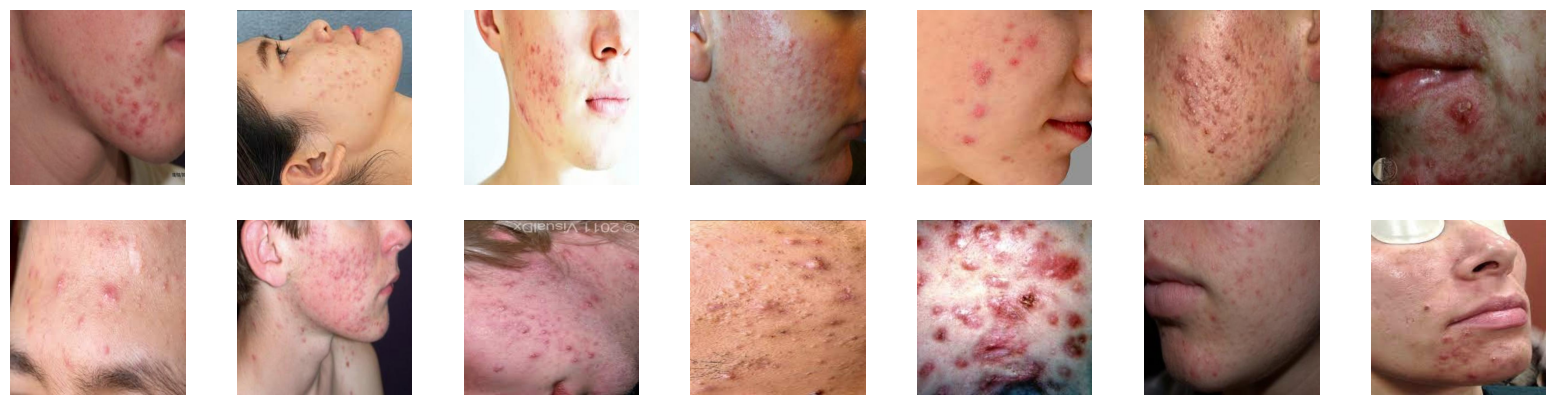

In [10]:
#training images
plt.figure(figsize=(20,5))
for i, c in enumerate(np.random.randint(0, len(train_images), size=14), start=1):
    plt.subplot(2,7,i)
    im = plt.imread(train_path+'/images/'+train_images[c])
    plt.axis('off')
    plt.imshow(im, cmap='gray')

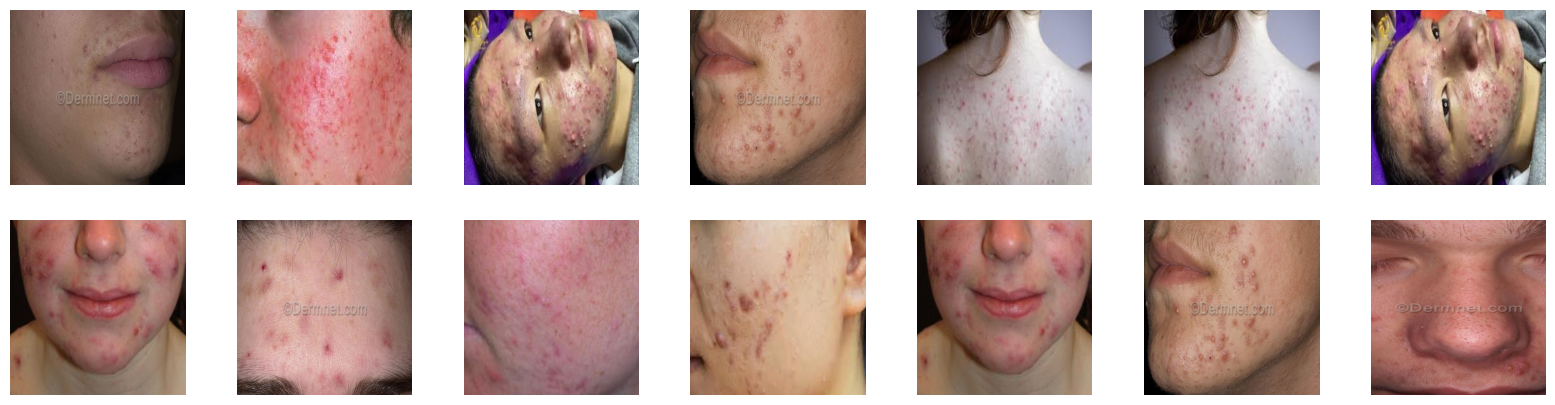

In [11]:
#testing images
plt.figure(figsize=(20,5))
for i, c in enumerate(np.random.randint(0, len(test_images), size=14), start=1):
    plt.subplot(2,7,i)
    im = plt.imread(test_path+'/images/'+test_images[c])
    plt.axis('off')
    plt.imshow(im, cmap='gray')

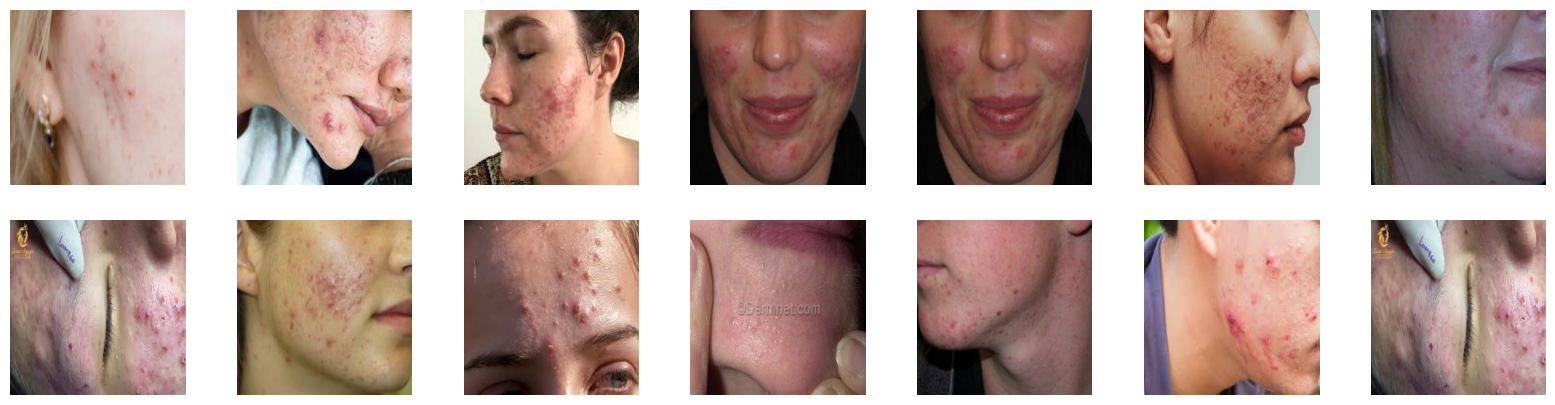

In [12]:
#valid images
plt.figure(figsize=(20,5))
for i, c in enumerate(np.random.randint(0, len(val_images), size=14), start=1):
    plt.subplot(2,7,i)
    im = plt.imread(val_path+'/images/'+val_images[c])
    plt.axis('off')
    plt.imshow(im, cmap='gray')

In [13]:
from ultralytics import YOLO
import shutil

# Initialize the model
model = YOLO('yolov8n.yaml')  # Choose the appropriate model variant

# Train the model
results = model.train(data="/content/drive/MyDrive/AcneDataset/data.yaml", epochs=10, imgsz=640)

# Define the path where you want to save the trained model
model_path = "/content/drive/MyDrive/AcneDataset/trained_model.pt"

# Get the best model path from the results
best_model_path = results.best

# Copy the best model to the desired location
shutil.copy(best_model_path, model_path)

print(f"Model saved to {model_path}")


Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/AcneDataset/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, 

train: Scanning /content/drive/MyDrive/AcneDataset/train/labels.cache... 823 images, 12 backgrounds, 0 corrupt: 100%|██████████| 823/823 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/AcneDataset/valid/labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.27G       4.97      3.752      3.953         98        640: 100%|██████████| 52/52 [00:23<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all         56        643   0.000238    0.00622   0.000122   5.48e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.36G      3.447      2.671      2.945         59        640: 100%|██████████| 52/52 [00:19<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         56        643     0.0903      0.185     0.0441     0.0107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.37G      2.873      2.273      2.404         60        640: 100%|██████████| 52/52 [00:18<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         56        643      0.338      0.372      0.266     0.0816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.24G      2.642      2.109      2.161        106        640: 100%|██████████| 52/52 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all         56        643      0.407      0.386      0.353      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.32G      2.539      2.012      2.015         83        640: 100%|██████████| 52/52 [00:18<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all         56        643      0.321      0.429        0.3      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.36G      2.467      1.958      1.967        108        640: 100%|██████████| 52/52 [00:18<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         56        643      0.461      0.427      0.413      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.27G      2.401       1.84       1.87         73        640: 100%|██████████| 52/52 [00:18<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         56        643       0.41      0.456        0.4      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.16G      2.364      1.826      1.856         97        640: 100%|██████████| 52/52 [00:18<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         56        643       0.47      0.464      0.444       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.26G      2.311      1.769        1.8         95        640: 100%|██████████| 52/52 [00:18<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         56        643       0.48      0.489       0.46      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.27G      2.298      1.732      1.776        174        640: 100%|██████████| 52/52 [00:18<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

                   all         56        643      0.514      0.479      0.484      0.187



10 epochs completed in 0.061 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


                   all         56        643      0.514      0.479      0.484      0.187
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/train2


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


AttributeError: 'Run' object has no attribute '_backend'

In [14]:
from ultralytics import YOLO
import shutil

# Initialize the model
model = YOLO('yolov8n.yaml')  # Choose the appropriate model variant

# Train the model
results = model.train(data="/content/drive/MyDrive/AcneDataset/data.yaml", epochs=10, imgsz=320)

# Define the path where you want to save the trained model
model_path = "/content/drive/MyDrive/AcneDataset/trained_model.pt"

# Get the best model path from the model object
best_model_path = model.best

# Copy the best model to the desired location
shutil.copy(best_model_path, model_path)

print(f"Model saved to {model_path}")

Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/AcneDataset/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, 

train: Scanning /content/drive/MyDrive/AcneDataset/train/labels.cache... 823 images, 12 backgrounds, 0 corrupt: 100%|██████████| 823/823 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/AcneDataset/valid/labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.76G      6.211       4.44      3.879         98        320: 100%|██████████| 52/52 [00:20<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         56        643   5.95e-05    0.00156   2.99e-05    1.5e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.07G      4.756       3.13      2.876         59        320: 100%|██████████| 52/52 [00:11<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         56        643   0.000417     0.0109   0.000218   9.18e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.04G      3.788      2.308      2.155         60        320: 100%|██████████| 52/52 [00:12<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

                   all         56        643       0.23      0.193      0.108     0.0248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.05G      3.237      1.945       1.82        106        320: 100%|██████████| 52/52 [00:14<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         56        643      0.273      0.283      0.151     0.0374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.07G      3.006      1.869      1.638         83        320: 100%|██████████| 52/52 [00:09<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all         56        643      0.394       0.33       0.29     0.0798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.03G      2.897      1.813      1.591        108        320: 100%|██████████| 52/52 [00:13<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.22it/s]

                   all         56        643       0.38      0.345      0.281     0.0823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.05G      2.789      1.716      1.512         73        320: 100%|██████████| 52/52 [00:12<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         56        643      0.427      0.435      0.359      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.05G      2.763      1.699      1.519         97        320: 100%|██████████| 52/52 [00:10<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         56        643      0.449      0.419      0.376       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.05G      2.701      1.656      1.469         95        320: 100%|██████████| 52/52 [00:15<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         56        643      0.455      0.457      0.397      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.05G      2.643      1.627      1.444        174        320: 100%|██████████| 52/52 [00:17<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         56        643      0.478      0.457      0.414      0.139



10 epochs completed in 0.044 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


                   all         56        643      0.484      0.456      0.414      0.139
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train3


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


AttributeError: 'Run' object has no attribute '_backend'

In [15]:
input_image = cv2.imread('/content/drive/MyDrive/AcneDataset/test/images/acne-206_jpg.rf.8c9e6075fe0cfed1632f82cf23a2d9e4.jpg')

results = model.predict(source=input_image, conf=0.25)


0: 640x640 13 Acnes, 12.6ms
Speed: 2.3ms preprocess, 12.6ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


In [17]:
results[0].boxes.xyxy

tensor([[335.9593, 489.7887, 349.4717, 506.1728],
        [483.3217,  43.6412, 503.5952,  74.5936],
        [151.8703,  36.6113, 166.1236,  60.2411],
        [391.5646, 565.8713, 404.9343, 586.0513],
        [428.9626, 422.2718, 450.2608, 453.4715],
        [339.7583, 555.0095, 364.3683, 583.1963],
        [312.6124, 197.0477, 333.7678, 232.6985],
        [296.3134, 139.0605, 317.5216, 175.3950],
        [146.6721, 211.6623, 173.1971, 246.8041],
        [325.0110, 532.8271, 336.8300, 546.5271],
        [394.6220, 428.6968, 411.8029, 452.5686],
        [333.8359, 487.0319, 349.6431, 507.0694],
        [364.2551, 610.9122, 387.3655, 638.2889]], device='cuda:0')

In [18]:
results[0].boxes.conf

tensor([0.5385, 0.4915, 0.4878, 0.4422, 0.4206, 0.3967, 0.3836, 0.3676, 0.3493, 0.3377, 0.3317, 0.3146, 0.2662], device='cuda:0')

In [19]:
results[0].boxes.cls

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [20]:
classNames = ["Acne"]

In [21]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [22]:
!pip install cvzone
!pip install opencv-python

  Preparing metadata (setup.py) ... done
  Created wheel for cvzone: filename=cvzone-1.6.1-py3-none-any.whl size=26298 sha256=5e0fe49b562cee709b3156b560d76e91b786eedf465db8cff9e21e242139fbd9
  Stored in directory: /root/.cache/pip/wheels/2c/9f/b3/92e945ac4a71bf727a92463f38155cc5a4fa49c5010b38ec4c
Successfully built cvzone


In [23]:
import cv2
import cvzone
import math
from IPython.display import Image

In [38]:
results = model(input_image, stream=True)
for r in results:
    boxes = r.boxes
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        w, h = x2-x1, y2-y1
        cvzone.cornerRect(input_image, (x1, y1, w, h))

        conf = math.ceil((box.conf[0]*100))/100

        cls = box.cls[0]
        name = classNames[int(cls)]

        cvzone.putTextRect(input_image, f'{name} 'f'{conf}', (max(0,x1), max(35,y1)), scale = 0.5)

cv2.imwrite('/content/output.jpg', input_image)


0: 640x640 (no detections), 10.8ms
Speed: 2.2ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


True

In [36]:
# recommendations based on acne severity
recommendations = {
    "mild": ["Gentle cleanser", "Salicylic acid spot treatment", "Oil-free moisturizer"],
    "moderate": ["Benzoyl peroxide cleanser", "Retinoid cream", "Non-comedogenic moisturizer"],
    "severe": ["Prescription-strength retinoid", "Oral antibiotics", "Consult a dermatologist"]
}

def generate_recommendations(acne_detection_results):
    acne_count = len(acne_detection_results)

    if acne_count < 5:
        severity = "mild"
    elif acne_count < 10:
        severity = "moderate"
    else:
        severity = "severe"

    skincare_recommendations = recommendations[severity]

    return skincare_recommendations

# usage
acne_detection_results = model.predict("/content/drive/MyDrive/AcneDataset/train/images/acne-101_jpeg.rf.af45ba09bf2981ed7cc4af94b54aae48.jpg")
recommendations = generate_recommendations(acne_detection_results)

# Print the recommendations
print("Skincare Recommendations:")
for recommendation in recommendations:
    print("- " + recommendation)


image 1/1 /content/drive/MyDrive/AcneDataset/train/images/acne-101_jpeg.rf.af45ba09bf2981ed7cc4af94b54aae48.jpg: 640x640 8 Acnes, 18.5ms
Speed: 2.6ms preprocess, 18.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)
Skincare Recommendations:
- Gentle cleanser
- Salicylic acid spot treatment
- Oil-free moisturizer



0: 640x640 23 Acnes, 21.2ms
Speed: 2.2ms preprocess, 21.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


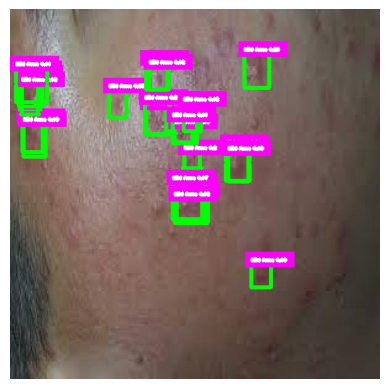

In [42]:
from ultralytics import YOLO
import cv2
import cvzone
import math
from IPython.display import display
from PIL import Image as PILImage
import matplotlib.pyplot as plt
import locale

# Ensure correct locale encoding
locale.getpreferredencoding = lambda: "UTF-8"

# Install necessary packages
!pip install cvzone opencv-python

# Load the trained model
model_path = "/content/runs/detect/train/weights/best.pt"
model = YOLO(model_path)

# Read the input image
input_image_path = '/content/drive/MyDrive/AcneDataset/test/images/acne-112_jpeg.rf.a03c796422719e964f46be1c118861bc.jpg'
input_image = cv2.imread(input_image_path)

# Predict using the model with a lower confidence threshold
results = model.predict(source=input_image, conf=0.1)

# Process and display the results
classNames = ["Mild Acne", "Moderate Acne", "Severe Acne", "Other Conditions"]

# Draw bounding boxes on the image
for r in results:
    boxes = r.boxes
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        w, h = x2 - x1, y2 - y1
        cvzone.cornerRect(input_image, (x1, y1, w, h))

        conf = math.ceil((box.conf[0] * 100)) / 100
        cls = box.cls[0]
        name = classNames[int(cls)]

        cvzone.putTextRect(input_image, f'{name} {conf}', (max(0, x1), max(35, y1)), scale=0.5)

# Save the output image
output_image_path = '/content/output.jpg'
cv2.imwrite(output_image_path, input_image)

# Display the output image using matplotlib
output_image = PILImage.open(output_image_path)
plt.imshow(output_image)
plt.axis('off')  # Hide the axis
plt.show()


In [44]:
# Define detailed skincare recommendations based on acne severity
recommendations = {
    "Mild Acne": ["Gentle cleanser", "Salicylic acid spot treatment", "Oil-free moisturizer", "Avoid heavy makeup", "Use sunscreen daily"],
    "Moderate Acne": ["Benzoyl peroxide cleanser", "Retinoid cream", "Non-comedogenic moisturizer", "Consult a dermatologist for potential oral antibiotics"],
    "Severe Acne": ["Prescription-strength retinoid", "Oral antibiotics", "Consult a dermatologist for potential hormonal treatments", "Avoid picking or squeezing pimples"],
    "Other Conditions": ["Consult a dermatologist for a proper diagnosis", "Avoid self-medication", "Use gentle skincare products"]
}

# Process YOLO model output and generate detailed recommendations
def generate_recommendations(acne_detection_results):
    # Process the acne detection results (e.g., count acne regions, determine severity)
    acne_count = len(acne_detection_results[0].boxes)

    # Collect detected conditions
    detected_conditions = {}
    for box in acne_detection_results[0].boxes:
        cls = classNames[int(box.cls[0])]
        if cls not in detected_conditions:
            detected_conditions[cls] = 1
        else:
            detected_conditions[cls] += 1

    # Lookup skincare recommendations based on detected conditions
    skincare_recommendations = {}
    for condition, count in detected_conditions.items():
        skincare_recommendations[condition] = recommendations[condition]

    return skincare_recommendations

# Example usage
acne_detection_results = model.predict(input_image_path, conf=0.1)
recommendations = generate_recommendations(acne_detection_results)

# Print the recommendations
print("Skincare Recommendations:")
for condition, recs in recommendations.items():
    print(f"{condition}:")
    for rec in recs:
        print(f"- {rec}")



image 1/1 /content/drive/MyDrive/AcneDataset/test/images/acne-112_jpeg.rf.a03c796422719e964f46be1c118861bc.jpg: 640x640 23 Acnes, 12.4ms
Speed: 2.7ms preprocess, 12.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)
Skincare Recommendations:
Mild Acne:
- Gentle cleanser
- Salicylic acid spot treatment
- Oil-free moisturizer
- Avoid heavy makeup
- Use sunscreen daily
